In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
from functools import partial
%matplotlib widget

In [2]:
jax.config.update("jax_enable_x64", False)

In [3]:
@partial(jax.jit, static_argnames=("f",))
def midpoint_rule_first_(f, a, b ):
    """Midpoint rule for integration on [a,b] with 1 interval

    Args:
        f (function): function to integrate
        a (float): lower bound
        b (float): upper bound

    Returns:
        float: integral
    """
    return (b-a)*f((a+b)/2)
    

@partial(jax.jit, static_argnames=("f",))
def midpoint_rule_next_(f : callable, a : float, b : float, N : int, s : float ):
    """Midpoint rule for integration on [a,b] with 3^(N-2) intervals

    Args:   
        f (callable): function to integrate
        a (float): lower bound
        b (float): upper bound
        N (int): recursion level
        s (float): previous result

    Returns:
        _type_: _description_
    """
    it = 3**(N-2)
    delta = (b-a)/(3.0*it)
    # sum= jnp.sum( f( jnp.arange(a+delta/2, b, 3*delta) ) )
    sum = jax.lax.fori_loop(0, it, lambda i, sum: sum + f(a+delta/2+i*3*delta), 0.0)
    # sum+= jnp.sum( f( jnp.arange(a+5*delta/2, b, 3*delta) ) )
    sum = jax.lax.fori_loop(0, it, lambda i, sum: sum + f(a+5*delta/2+i*3*delta), sum)

    return (s+(b-a)*sum/it)/3.0

@partial(jax.jit, static_argnames=("f",))
def midpoint_rule(f : callable, a : float, b : float, epsabs : float = 0.0 , epsrel : float = 1e-6 ):
    """Midpoint rule for integration on [a,b] with error control

    Args:
        f (callable): function to integrate
        a (float): lower bound
        b (float): upper bound
        epsabs (float, optional): absolute error bound. Defaults to 0.0.
        epsrel (float, optional): relative error bound. Defaults to 1e-6.

    Returns:
        float,float: integral, error estimate   
    """
    Nmax = 11
    N = 2
    s_old = midpoint_rule_first_(f, a, b)
    s     = midpoint_rule_next_(f, a, b, N, s_old)
    while N<Nmax:
        # err = jnp.abs(s-s_old)
        # if err<epsabs or err<epsrel*jnp.abs(s):
        #     print("N=",N)
        #     return s
        s_old = s
        s = midpoint_rule_next_(f, a, b, N+1, s_old)
        N += 1
    err = jnp.abs(s-s_old)
    return s,err  # return s_old

@partial(jax.jit, static_argnames=("f",))
def midpoint_zero_inf( f, epsabs=0.0, epsrel=1e-6 ):
    """Midpoint rule for integration on [0,inf] with error control

    Args:
        f (callable): function to integrate
        epsabs (float, optional): absolute error bound. Defaults to 0.0.
        epsrel (float, optional): relative error bound. Defaults to 1e-6.

    Returns:
        float,float: integral, error estimate
    """
    g = lambda x: f(-jnp.log(x)) / x
    return midpoint_rule( g, 0.0, 1.0, epsabs=epsabs, epsrel=epsrel )

In [4]:
## reference implementation with numpy/scipy
def Omega_nu_numpy_(a, mnu, Tcmb, h):
    # a is the scale factor
    # Tcmb is the temperature of the CMB
    # H0 is the Hubble constant
    # h is the reduced Hubble constant
    # Omega_nu is the density of neutrinos
    # Omega_nu = 7*pi^4/120 * (T_nu/T_cmb)^4 * (4/11)^(4/3) * (1/1.68)
    sum = 0.0
    g   = 2.0 # number of degrees of freedom
    Tnu = (4.0/11.0)**(1.0/3.0) * Tcmb # Temperature of neutrinos
    c2ok = 1.62581581e4 # K / eV
    for m in mnu:
        beta = m/Tnu * c2ok
        def integ(y):
            return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)
        res  = scipy.integrate.quad(integ, 0, np.inf)#, epsabs=1e-13, epsrel=1e-10)
        sum += res[0] * (m/6.32264e-3)**4
    return sum * a**-3 * h**-2 * g

def Omega_nu_numpy( a, mnu, Tcmb, h ):
    res = np.zeros_like(a)
    for i, ai in enumerate(a):
        res[i] = Omega_nu_numpy_(ai, mnu, Tcmb, h)
    return res

In [5]:
@jax.jit
def integ_omega_nu(y, a, mnu, Tcmb):
    """Integrand of the neutrino Fermi-Dirac integral

    Args:
        y (float): integration variable
        a (float): scale factor
        mnu (ndarray): neutrino masses (meV/c^2)
        Tcmb (float): CMB temperature (K)

    Returns:
        float: integrand
    """
    g   = 2.0 # number of degrees of freedom
    Tnu = (4.0/11.0)**(1.0/3.0) * Tcmb # Temperature of neutrinos
    c2ok = 1.62581581e4 # c^2/k_B in K / eV
    f = 0.0
    for m in mnu:
        beta = m/Tnu * c2ok
        f += y**2 * jnp.sqrt(1.+y**2/a**2) / (jnp.exp(beta*y) + 1.) * (m/6.32264e-3)**4
    return f * g

def Omega_nu_(a, mnu, Tcmb, h):
    """Massive neutrino density parameter

    Args:
        a (float): scale factor
        mnu (ndarray): neutrino masses (meV/c^2)
        Tcmb (float): CMB temperature (K)
        h (float): reduced Hubble constant

    Returns:
        float: density parameter
    """
    res, err = midpoint_zero_inf( lambda y: integ_omega_nu(y,a,mnu,Tcmb), epsabs=0, epsrel=1e-8)
    return res * a**-3 * h**-2, err * a**-3 * h**-2

def Omega_nu( a, mnu, Tcmb=2.7255, h=0.6736 ):
    """Massive neutrino density parameter (vectorized)

    Args:
        a (ndarray): array of scale factors
        mnu (ndarray): neutrino masses (meV/c^2)
        Tcmb (float, optional): CMB temperature today. Defaults to 2.7255.
        h (float, optional): reduced Hubble constant. Defaults to 0.6736.

    Returns:
        float, float: density parameter at values of a, error estimate
    """
    res = jnp.zeros_like(a)
    err = jnp.zeros_like(a)
    
    for i, ai in enumerate(a):
        Onu, eOnu = Omega_nu_(ai, mnu, Tcmb, h)
        res = res.at[i].set( Onu )
        err = res.at[i].set( eOnu )
    return res, err


/var/folders/m8/1yjz77r957vbsrx_2s2hdj1r0000gn/T/ipykernel_61657/2844311021.py:16: RuntimeWarning: overflow encountered in exp
  return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)
/var/folders/m8/1yjz77r957vbsrx_2s2hdj1r0000gn/T/ipykernel_61657/2844311021.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res  = scipy.integrate.quad(integ, 0, np.inf)#, epsabs=1e-13, epsrel=1e-10)


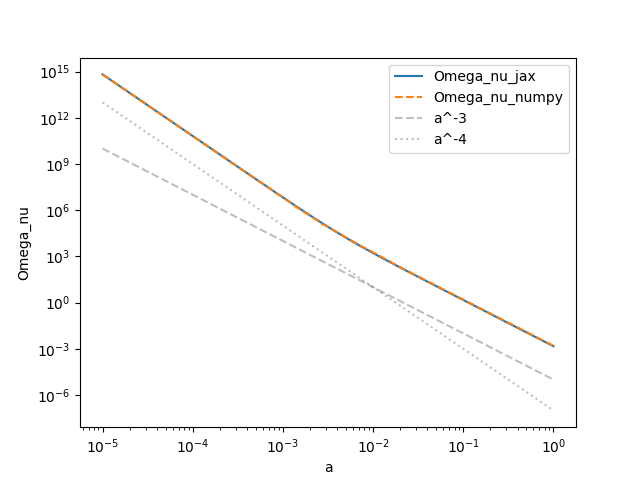

In [6]:
aa = jnp.geomspace(1e-5,1.0,100)

mnus = [0.1,0.07]

Omega_nu, errOn = Omega_nu(aa, mnus, Tcmb=2.7255, h=0.67)

fig, ax = plt.subplots()
ax.loglog(aa, Omega_nu, label='Omega_nu_jax')
ax.loglog(aa, Omega_nu_numpy(aa, mnus, Tcmb=2.7255, h=0.67), '--', label='Omega_nu_numpy')

ax.set_xlabel('a')
ax.set_ylabel('Omega_nu')
ax.loglog(aa,1e-5*aa**-3, c='k', ls='--', label='a^-3', alpha=0.25)
ax.loglog(aa,1e-7*aa**-4, c='k', ls=':',  label='a^-4', alpha=0.25)
ax.legend()
